# Analysing All Time AFL Games Data

https://afltables.com/afl/stats/biglists/bg3.txt

This website contains data on every AFL match ever played, and appears to be updated weekly during the AFL season.

In this notebook I'm going to scrape this data from the website into a dataframe and analyse it in ways that show some interesting things.

I'm also going to create a dynamic league ladder that can show the standings as at any selected point in time!

### Import data

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
%matplotlib inline

In [2]:
df = pd.read_table('https://afltables.com/afl/stats/biglists/bg3.txt', 
                   delimiter=r'[.\s]\s{1,}', engine='python', parse_dates=True)

df.reset_index(inplace=True)

df.drop(['level_0'], axis=1, inplace=True)

df.columns = ['date','round','home team','home score','away team','away score','venue']

In [3]:
# data read to a dataframe

df.head()

,date,round,home team,home score,away team,away score,venue
0,1897-05-08,R1,Fitzroy,6.13.49,Carlton,2.4.16,Brunswick St
1,1897-05-08,R1,Collingwood,5.11.41,St Kilda,2.4.16,Victoria Park
2,1897-05-08,R1,Geelong,3.6.24,Essendon,7.5.47,Corio Oval
3,1897-05-08,R1,South Melbourne,3.9.27,Melbourne,6.8.44,Lake Oval
4,1897-05-15,R2,South Melbourne,6.4.40,Carlton,5.6.36,Lake Oval


### Data cleaning

In [4]:
df.replace('South Melbourne', value='Sydney/South Melbourne', inplace=True)

df.replace('Sydney', value='Sydney/South Melbourne', inplace=True)

df.replace('Kangaroos', value='North Melbourne', inplace=True)

df.replace('Footscray', value='Western Bulldogs/Footscray', inplace=True)

df.replace('Western Bulldogs', value='Western Bulldogs/Footscray', inplace=True)

In [5]:
df['home goals'] = df['home score'].apply(lambda x: x.split('.')[0])

df['home behinds'] = df['home score'].apply(lambda x: x.split('.')[1])

df['home score'] = df['home score'].apply(lambda x: x.split('.')[2])

In [6]:
df['away goals'] = df['away score'].apply(lambda x: x.split('.')[0])

df['away behinds'] = df['away score'].apply(lambda x: x.split('.')[1])

df['away score'] = df['away score'].apply(lambda x: x.split('.')[2])

In [7]:
df[['home goals','home score','home behinds','away goals','away behinds','away score']] = df[['home goals','home score','home behinds','away goals','away behinds','away score']].astype(int)

### Create additional columns

In [8]:
df['home team win margin'] = df['home score'] - df['away score']

df['margin'] = (((df['home score'] - df['away score'])**2)**0.5).astype(int)

In [9]:
df['total score'] = df['home score'] + df['away score']

In [10]:
def func1 (i):
    if i > 0:
        return 'home'
    elif i == 0:
        return 'draw'
    else:
        return 'away'

In [11]:
df['winning side'] = df['home team win margin'].apply(func1)

In [12]:
df = df[['date','round','home team','home goals','home behinds','home score','away team','away goals','away behinds','away score','venue','total score','winning side','home team win margin','margin']]

In [13]:
df['winning team'] = np.where(df['winning side'] == 'home', df['home team'], np.where(df['winning side'] == 'away', df['away team'], 'draw'))

In [14]:
df['losing team'] = np.where(df['winning side'] == 'home', df['away team'], np.where(df['winning side'] == 'away', df['home team'], 'draw'))

In [15]:
# dataframe output

df.head()

,date,round,home team,home goals,home behinds,home score,away team,away goals,away behinds,away score,venue,total score,winning side,home team win margin,margin,winning team,losing team
0,1897-05-08,R1,Fitzroy,6,13,49,Carlton,2,4,16,Brunswick St,65,home,33,33,Fitzroy,Carlton
1,1897-05-08,R1,Collingwood,5,11,41,St Kilda,2,4,16,Victoria Park,57,home,25,25,Collingwood,St Kilda
2,1897-05-08,R1,Geelong,3,6,24,Essendon,7,5,47,Corio Oval,71,away,-23,23,Essendon,Geelong
3,1897-05-08,R1,Sydney/South Melbourne,3,9,27,Melbourne,6,8,44,Lake Oval,71,away,-17,17,Melbourne,Sydney/South Melbourne
4,1897-05-15,R2,Sydney/South Melbourne,6,4,40,Carlton,5,6,36,Lake Oval,76,home,4,4,Sydney/South Melbourne,Carlton


### Average total match score by season

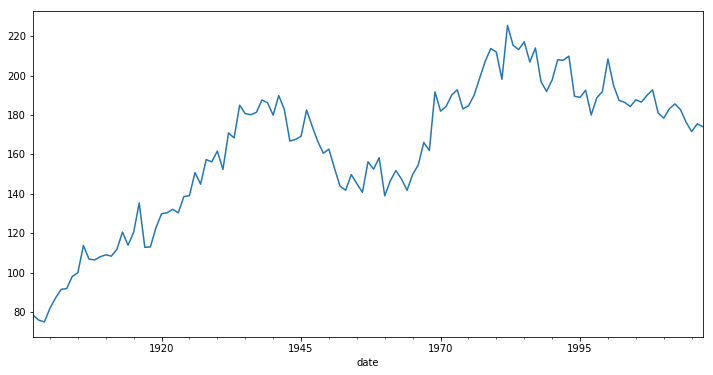

In [16]:
# average total score per season

df.groupby('date').mean().resample('A').mean()['total score'].plot(figsize=(12,6))

### Home ground advantage by ground

In [17]:
df_hgadv = df.groupby(['venue', 'winning side']).count()[['date']]

In [18]:
df_hgadv = df_hgadv.unstack()

In [19]:
df_hgadv = df_hgadv['date']

In [20]:
df_hgadv = df_hgadv.fillna(0)

In [21]:
df_hgadv['total'] = df_hgadv['home'] + df_hgadv['away'] + df_hgadv['draw']

In [22]:
df_hgadv['home win %'] = df_hgadv['home'] / df_hgadv['total']

In [23]:
df_hgadv[df_hgadv['total'] >= 500].sort_values('home win %', ascending=False)

winning side,away,draw,home,total,home win %
venue,,,,,
Victoria Park,222.0,5.0,653.0,880.0,0.742045
Princes Park,380.0,16.0,881.0,1277.0,0.689898
Windy Hill,201.0,9.0,419.0,629.0,0.666137
Kardinia Park,216.0,5.0,440.0,661.0,0.665658
Subiaco,188.0,1.0,356.0,545.0,0.653211
M.C.G.,1039.0,29.0,1725.0,2793.0,0.617615
Punt Rd,224.0,6.0,314.0,544.0,0.577206
Brunswick St,255.0,13.0,344.0,612.0,0.562092
Lake Oval,311.0,8.0,385.0,704.0,0.546875


### Home ground advantage by season

In [24]:
df_hgadv2 = df.groupby(['date', 'winning side']).count()[['venue']]

In [25]:
df_hgadv2 = df_hgadv2.reset_index()

In [26]:
df_hgadv2 = df_hgadv2.groupby([df_hgadv2['date'].map(lambda x: x.year), 'winning side']).sum().reset_index()

In [27]:
df_hgadv2 = df_hgadv2.pivot(index='date', columns='winning side', values='venue')

In [28]:
df_hgadv2['draw'].fillna(value=0, inplace=True)

In [29]:
df_hgadv2['total'] = df_hgadv2['home'] + df_hgadv2['away'] + df_hgadv2['draw']

In [30]:
df_hgadv2['home win%'] = df_hgadv2['home'] / df_hgadv2['total']

In [31]:
df_hgadv2.head()

winning side,away,draw,home,total,home win%
date,,,,,
1897,26.0,1.0,35.0,62.0,0.564516
1898,23.0,1.0,46.0,70.0,0.657143
1899,30.0,0.0,39.0,69.0,0.565217
1900,17.0,0.0,53.0,70.0,0.757143
1901,31.0,1.0,39.0,71.0,0.549296


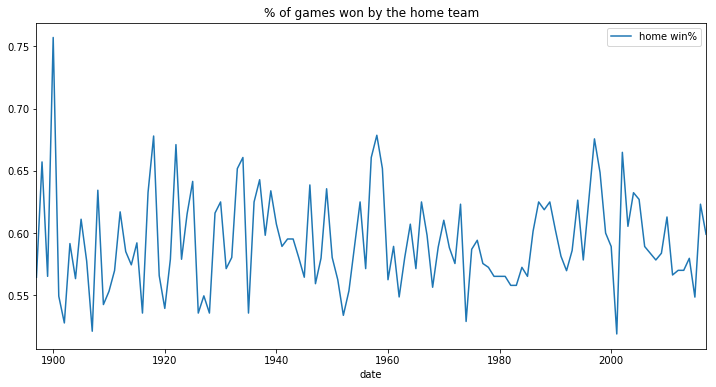

In [32]:
df_hgadv2.plot(y='home win%', figsize=(12,6), title='% of games won by the home team')

### Create a dataframe for each team containing only their games

In [33]:
teams = df['home team'].unique()

In [34]:
df_ = {}

for i in teams:
    df_[i] = pd.DataFrame(df[(df['home team'] == i) | (df['away team'] == i)])

In [35]:
df_['Richmond'].head()

,date,round,home team,home goals,home behinds,home score,away team,away goals,away behinds,away score,venue,total score,winning side,home team win margin,margin,winning team,losing team
774,1908-05-02,R1,Richmond,8,14,62,Melbourne,7,9,51,Punt Rd,113,home,11,11,Richmond,Melbourne
779,1908-05-09,R2,University,14,10,94,Richmond,12,4,76,East Melbourne,170,home,18,18,University,Richmond
782,1908-05-16,R3,Richmond,7,13,55,Fitzroy,11,14,80,Punt Rd,135,away,-25,25,Fitzroy,Richmond
786,1908-05-23,R4,Essendon,11,16,82,Richmond,6,9,45,East Melbourne,127,home,37,37,Essendon,Richmond
792,1908-05-30,R5,Richmond,8,17,65,Geelong,8,11,59,Punt Rd,124,home,6,6,Richmond,Geelong


### Richmond win% by season

In [36]:
rfc_wins = df_['Richmond'][df_['Richmond']['winning team'] == 'Richmond'].groupby('date').count().resample('A').count()[['round']]

In [37]:
rfc_wins.columns = ['wins']

In [38]:
rfc_games = df_['Richmond'].groupby('date').count().resample('A').count()[['round']]

In [39]:
rfc_games.columns = ['games']

In [40]:
rfc_wins = pd.concat([rfc_wins, rfc_games], axis=1)

rfc_wins['win%'] = rfc_wins['wins'] / rfc_wins['games']

In [41]:
rfc_winpc = rfc_wins.drop(['wins', 'games'], axis=1)

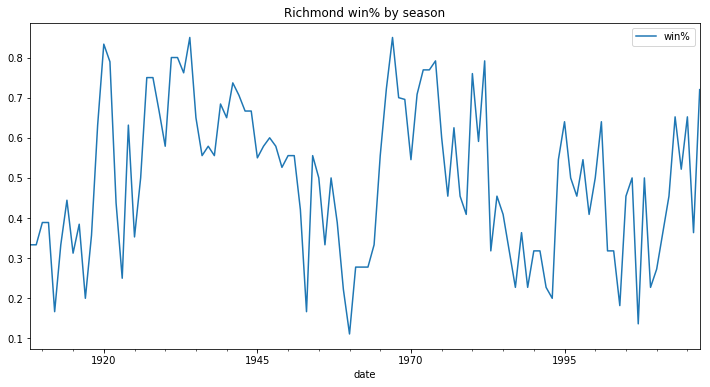

In [42]:
rfc_winpc.plot(figsize=(12,6), title='Richmond win% by season')

### Dynamic League Ladder

Here I have built a dynamic AFL league ladder that can show what the standings were at any point in time.

The date entered below is '2001-07-18', the ladder shows the standings on that day.

In [43]:
# select a date for the ladder

select_date = '2001-07-18'

In [44]:
yr = datetime.datetime.strptime(select_date, "%Y-%m-%d").year

In [45]:
start_date = str(yr)+'-01-01'

In [46]:
dfladder = df[(df['date'] > start_date) & (df['date'] <= select_date) & (~df['round'].isin(['QF', 'EF', 'SF', 'PF', 'GF']))]

In [47]:
# create won column

won = dfladder.groupby('winning team').count()[['date']].drop('draw', errors='ignore')

won.columns = ['won']

In [48]:
# create lost column

lost = dfladder.groupby('losing team').count()[['date']].drop('draw', errors='ignore')

lost.columns = ['lost']

In [49]:
# create for column

ptsforhome = dfladder.groupby('home team')[['home score']].sum()

In [50]:
ptsforaway = dfladder.groupby('away team')[['away score']].sum()

In [51]:
ptsfor = ptsforhome['home score'] + ptsforaway['away score']

In [52]:
ptsfor = pd.DataFrame(ptsfor)

In [53]:
ptsfor.columns = ['for']

In [54]:
# create against column

ptsagainsthome = dfladder.groupby('home team')[['away score']].sum()

In [55]:
ptsagainstaway = dfladder.groupby('away team')[['home score']].sum()

In [56]:
ptsagainst = ptsagainsthome['away score'] + ptsagainstaway['home score']

In [57]:
ptsagainst = pd.DataFrame(ptsagainst)

In [58]:
ptsagainst.columns = ['against']

In [59]:
# create games column

played = pd.concat([dfladder['home team'], dfladder['away team']], axis=0)

In [60]:
played = pd.DataFrame(played)

In [61]:
played.reset_index(inplace=True)

In [62]:
played.columns = ['games', 'index']

In [63]:
played = played.groupby('index').count()

In [64]:
played.reset_index(inplace=True)

In [65]:
played.set_index('index', inplace=True)

In [66]:
# construct ladder

ladder = pd.concat([played, won, lost, ptsfor, ptsagainst], axis=1)

In [67]:
ladder['drawn'] = ladder['games'] - ladder['won'] - ladder['lost']

In [68]:
ladder.fillna(0, inplace=True)

In [69]:
ladder['points'] = ladder['won']*4 + ladder['drawn']*2

In [70]:
ladder['%'] = ladder['for']*100 / ladder['against']

In [71]:
ladder = ladder[['games', 'won', 'drawn', 'lost', 'for', 'against', '%', 'points']]

In [72]:
title = 'AFL League Ladder for the year '+str(yr)+' as at '+select_date

ladder.index.name = title

In [73]:
ladder.sort_values(['points', '%'], ascending=False).astype(int)

,games,won,drawn,lost,for,against,%,points
AFL League Ladder for the year 2001 as at 2001-07-18,,,,,,,,
Essendon,15,13,0,2,1780,1212,146,52
Port Adelaide,15,10,0,5,1665,1321,126,40
Brisbane Lions,15,10,0,5,1703,1398,121,40
Hawthorn,15,10,0,5,1444,1377,104,40
Carlton,15,9,0,6,1557,1251,124,36
Richmond,15,9,0,6,1392,1364,102,36
Collingwood,15,8,0,7,1579,1386,113,32
Sydney/South Melbourne,15,8,0,7,1411,1335,105,32
North Melbourne,15,8,0,7,1449,1459,99,32


The selected date looks to be after round 15. We can verify this data with the AFL website ladder http://www.afl.com.au/ladder which shows round by round standings back to 1999. This dynamic ladder can show daily standings all the way back to 1897!

In [74]:
# ideas

# gap between the best and worst teams for each year
# most dominant seasons by win% in year, and %age in year
# most dominant finals campaigns
# most dominant 10 year period for a team
# home ground advantage over the years
# home ground advantage by venue
# chart premierships by teams over the years
# teams win % over the years
# dynamic league ladder